This version dropped body weight, and used both apsiii and oasis for PSM and regression analyses

Correction: AUC sld be roc_auc_score(y, **probas_**) NOT roc_auc_score(y, pred)

added apsiii and oasis in the covariate_table

https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pymatch.Matcher import Matcher
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [54]:
df = pd.read_csv('./data/df_clean_0424_CVICU.csv')
print(df.shape)
df.head()

(577, 29)


,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,resp_rate_first24h_mean,spo2_first24h_mean,...,heart_rhythm_first24h_firstRecorded,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat
0,10001884,9.0,1,0,77.01830,F,71.39286,86.03846,17.77586,98.25926,...,V Paced,2.0,6,2.0,10,6,2.0,56,34,rare rhythm
1,10024982,21.0,1,0,85.71412,M,63.11111,84.28000,19.24074,99.88889,...,AF (Atrial Fibrillation),2.0,7,2.0,2,1,2.0,100,45,AF (Atrial Fibrillation)
2,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,21.22917,97.57447,...,SR (Sinus Rhythm),2.0,10,2.0,10,6,2.0,86,52,SR (Sinus Rhythm)
3,10131457,11.0,0,0,41.21647,M,54.08333,90.55932,16.84167,99.33333,...,SB (Sinus Bradycardia),2.0,2,2.0,10,6,9.0,31,33,rare rhythm
4,10144145,15.0,1,0,55.00510,M,68.73077,63.44000,17.34615,98.92308,...,SR (Sinus Rhythm),1.0,5,2.0,9,5,2.0,109,33,SR (Sinus Rhythm)


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             577 non-null    int64  
 1   los                                    577 non-null    float64
 2   hospital_expire_flag                   577 non-null    int64  
 3   expose                                 577 non-null    int64  
 4   age                                    577 non-null    float64
 5   gender                                 577 non-null    object 
 6   heart_rate_first24h_mean               577 non-null    float64
 7   mbp_first24h_mean                      577 non-null    float64
 8   resp_rate_first24h_mean                577 non-null    float64
 9   spo2_first24h_mean                     577 non-null    float64
 10  heart_rate_first24h_max                577 non-null    float64
 11  mbp_fi

In [56]:
X = df.drop(['subject_id', 'los','hospital_expire_flag','expose',
    'mbp_first24h_mean', 'resp_rate_first24h_mean', 'spo2_first24h_mean',
    'mbp_first24h_min',  'resp_rate_first24h_min',  'spo2_first24h_min', 'heart_rate_first24h_min',
    'mbp_first24h_max',  'resp_rate_first24h_max',  'spo2_first24h_max', 'heart_rate_first24h_max',     
    'first_gcs_motor_eyes', 'last_gcs_motor_eyes', 'heart_rhythm_first24h_firstRecorded', 'icu_entrydate_weekend',
    'heart_rhythm_first24h_numTypeRecorded'], axis=1)

X = pd.get_dummies(X, columns=['gender','heart_rhythm_cat'], drop_first=True)
y = df['expose']

In [8]:
X.columns

Index(['age', 'heart_rate_first24h_mean', 'charlson_comorbidity_index',
       'lowest_gcs_motor_eyes_first24h', 'last_gcs_motor', 'apsiii', 'oasis',
       'gender_M', 'heart_rhythm_cat_SR (Sinus Rhythm)',
       'heart_rhythm_cat_ST (Sinus Tachycardia) ',
       'heart_rhythm_cat_rare rhythm'],
      dtype='object')

In [9]:
param_grid = {'max_depth': [1, 2, 5, 10, 15],
         'n_estimators': [10, 20, 30, 50, 100],
         'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]}

lgbm = GridSearchCV(lgb.LGBMClassifier(
    boosting_type='gbdt', n_jobs=-1, random_state=1),
    param_grid=param_grid, cv=5, n_jobs=-1,
    scoring='roc_auc', refit = True)
lgbm.fit(X, y)
lgbm.best_params_

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 30}

In [10]:
lgbm_pred = lgbm.predict(X)
lgbm_probas_ = lgbm.predict_proba(X)
print('Accuracy:',accuracy_score(y, lgbm_pred))
print('AUC:', roc_auc_score(y, lgbm_probas_[:,1]))

Accuracy: 0.7764298093587522
AUC: 0.8597515197016299


In [11]:
df['score'] = lgbm_probas_[:, 1]

In [12]:
excl_covariates = ['subject_id', 'los','hospital_expire_flag','score',
    'mbp_first24h_mean', 'resp_rate_first24h_mean', 'spo2_first24h_mean',
    'mbp_first24h_min',  'resp_rate_first24h_min',  'spo2_first24h_min', 'heart_rate_first24h_min',
    'mbp_first24h_max',  'resp_rate_first24h_max',  'spo2_first24h_max', 'heart_rate_first24h_max',
    'first_gcs_motor_eyes', 'last_gcs_motor_eyes','heart_rhythm_first24h_firstRecorded', 'icu_entrydate_weekend',
    'heart_rhythm_first24h_numTypeRecorded']

test = df[df.expose==1]
control = df[df.expose==0]

m = Matcher(test, control, yvar="expose", exclude=excl_covariates)

Formula:
expose ~ age+gender+heart_rate_first24h_mean+charlson_comorbidity_index+lowest_gcs_motor_eyes_first24h+last_gcs_motor+apsiii+oasis+heart_rhythm_cat
n majority: 314
n minority: 263


In [13]:
np.random.seed(1234)
m.fit_scores(balance=True, nmodels=100)
m.predict_scores()
# ignore the accuracy score

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 75.64%


In [14]:
# lg_pred = np.where(m.data['scores']>=0.5,1,0)
print('AUC:', roc_auc_score(y, m.data['scores']))

AUC: 0.5437625632704464


In [15]:
m.data['scores'] = m.data['score']
m.data = m.data.drop(['score'],axis=1)
print('Accuracy:',accuracy_score(y, lgbm_pred))

Accuracy: 0.7764298093587522


In [16]:
# rec threshold
thresh = np.std(m.data['scores'])*0.2
thresh

0.05149305856146124

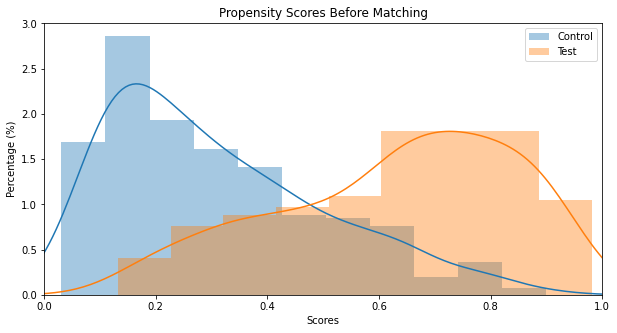

In [17]:
m.plot_scores()

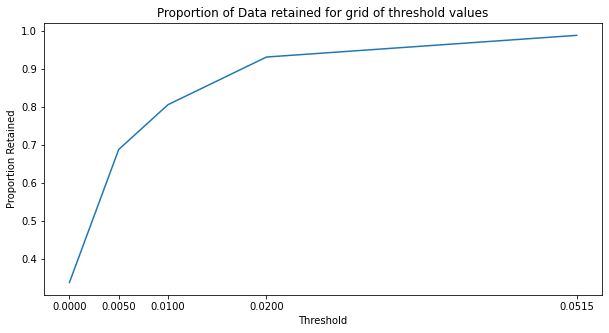

In [18]:
m.tune_threshold(method='random', rng=[0., 0.005, 0.01, 0.02, thresh])

In [19]:
m.match(method="random", nmatches=1, threshold=thresh)

In [20]:
m.record_frequency()

,freq,n_records
0,1,318
1,2,23
2,3,6
3,4,7
4,5,4
5,6,1
6,7,2
7,8,1
8,9,1
9,10,1


In [21]:
m.assign_weight_vector()

In [22]:
m.matched_data.sort_values("match_id").head(6)
m.matched_data.shape

(520, 33)

,var,before,after
0,gender,0.747718,0.646552
1,heart_rhythm_cat,0.067651,0.019286


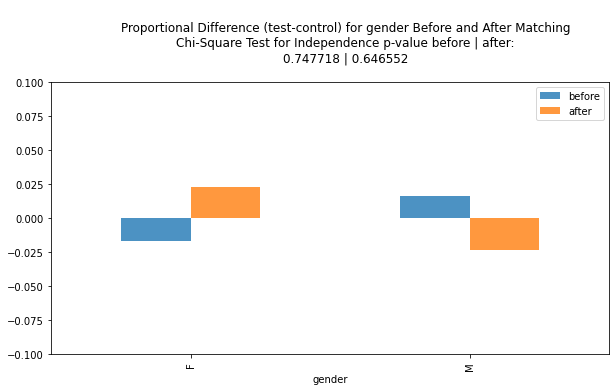

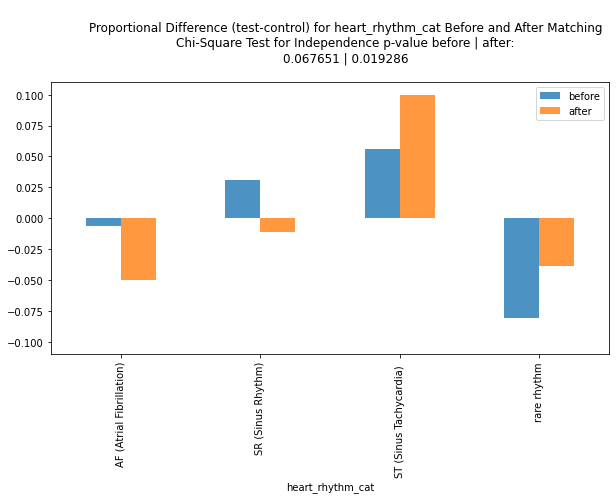

In [23]:
# compare before/after categorical features 
m.compare_categorical(return_table=True)

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.000,0.148,0.000,0.154,-0.328057,-0.011492,-0.343401,-0.066923
1,heart_rate_first24h_mean,0.000,0.353,0.000,0.005,-0.534931,0.070252,-0.571661,-0.002280
2,charlson_comorbidity_index,0.000,0.000,0.013,0.000,-0.343637,-0.307024,-0.433772,-0.380238
3,lowest_gcs_motor_eyes_first24h,0.000,0.488,1.000,1.000,0.000000,0.000000,-0.449929,0.078939
4,last_gcs_motor,0.000,0.191,1.000,1.000,-1.743873,0.868047,-0.583422,0.100159
5,apsiii,0.007,0.019,0.111,0.119,0.326205,-0.317718,0.223536,-0.224718
6,oasis,0.078,0.000,0.060,0.001,0.223490,-0.248430,0.079260,-0.274707


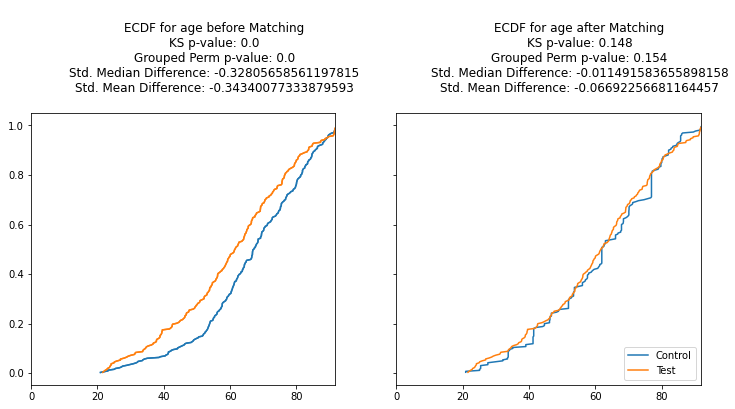

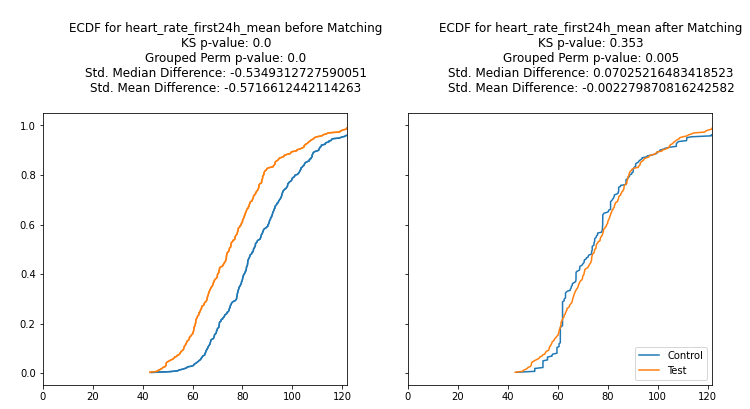

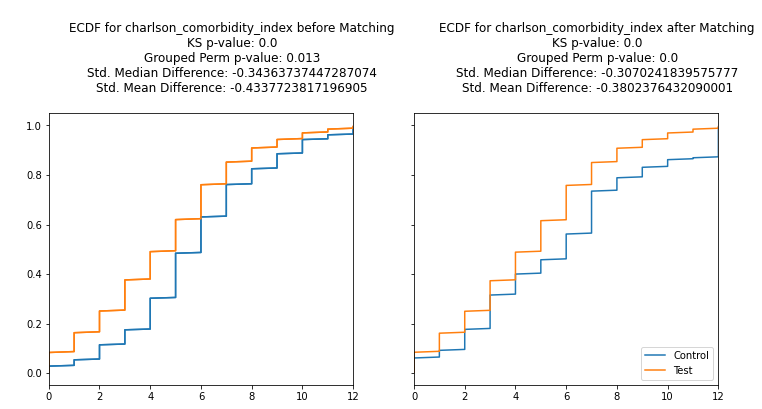

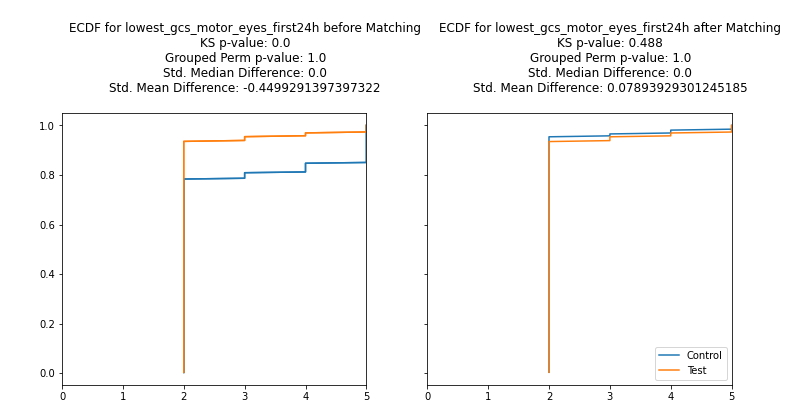

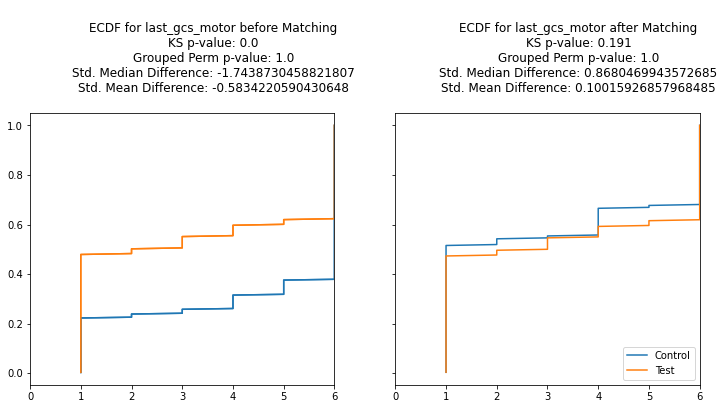

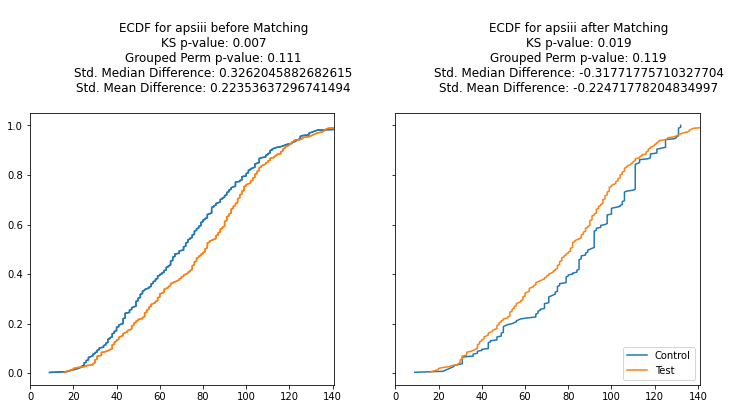

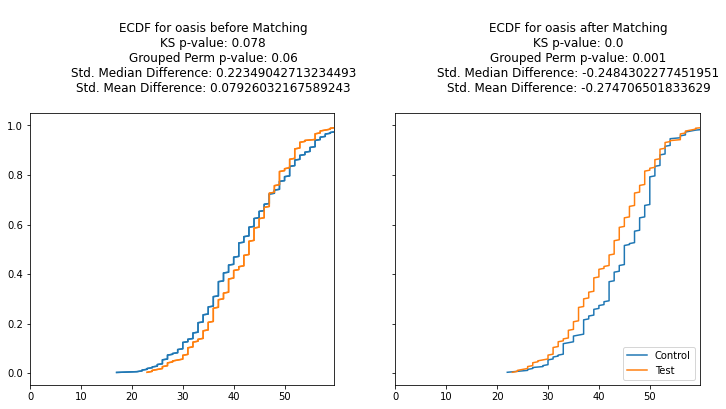

In [24]:
# compare before/after continuous features 
m.compare_continuous(return_table=True)

Increasing the number of untreated subjects matched to each treated subject tended to increase the bias in the estimated treatment effect; conversely, increasing the number of untreated subjects matched to each treated subject decreased the sampling variability of the estimated treatment effect. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2962254/

In [25]:
matched_1to1 = m.matched_data.sort_values("match_id")
matched_1to1.shape
matched_1to1['scores'].head()

0      0.153700
408    0.153700
1      0.431696
387    0.413327
2      0.661459
Name: scores, dtype: float64

In [27]:
# p = matched_1to1['scores']*matched_1to1['expose'] + (1-matched_1to1['scores'])*(1-matched_1to1['expose'])
# matched_1to1['ipw'] = 1 + np.exp(-np.log(p/(1-p)))
matched_1to1['ipw'] = 1+matched_1to1['scores']

matched_1to1['ipw_freq'] = matched_1to1['ipw']*matched_1to1['weight']
matched_1to1.shape

(520, 35)

In [28]:
#matched_1to1.rename(columns={'weight':'bodyweight'}, inplace=True)

In [29]:
matched_1to1.head()

,record_id,weight,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,...,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat,scores,match_id,ipw,ipw_freq
0,0,1.0,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,...,10,6,2.0,86,52,SR (Sinus Rhythm),0.153700,0,1.153700,1.153700
408,398,1.0,14482268,2.0,1,0,64.59555,F,108.30610,74.03922,...,9,6,5.0,61,44,SR (Sinus Rhythm),0.153700,0,1.153700,1.153700
1,1,1.0,10150911,7.0,0,1,58.80580,F,65.64286,88.43750,...,10,6,2.0,125,58,rare rhythm,0.431696,1,1.431696,1.431696
387,365,0.5,13370388,6.0,0,0,62.66466,M,82.68182,65.04348,...,10,6,9.0,69,40,ST (Sinus Tachycardia),0.413327,1,1.413327,0.706664
2,2,1.0,10172206,13.0,0,1,61.34548,M,57.56522,77.84615,...,10,6,6.0,98,47,rare rhythm,0.661459,2,1.661459,1.661459


In [30]:
from statsmodels.stats import weightstats as st
from statsmodels.stats import meta_analysis as mt

control = df[df['expose']==0]
treatment = df[df['expose']==1]

variables = [
    'age','heart_rate_first24h_mean','apsiii','oasis',
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h']

lst = []

for i in variables:
    row_fill = []
    row_fill.append(i)
    row_fill.append(np.mean(treatment[i]))
    row_fill.append(np.std(treatment[i]))
    row_fill.append(np.mean(control[i]))
    row_fill.append(np.std(control[i]))
    row_fill.append(abs(mt.effectsize_smd(row_fill[1],row_fill[2], treatment.shape[0],row_fill[3],row_fill[4],control.shape[0])[0]))
    t_value, p_value, degfree = st.ttest_ind(control[i],treatment[i],alternative="two-sided",usevar="pooled")
    row_fill.append(t_value)
    row_fill.append(p_value)
    lst.append(row_fill)

covariate_table = pd.DataFrame(lst, columns=['Variable Name', 'Exposure Mean', 'Exposure std', 'Non-Exposure Mean', 'Non-Exposure std', 'SMD','t-value', 'p-value'])

#covariate_table['p-value'] = covariate_table['p-value'].round(decimals=3)
covariate_table

,Variable Name,Exposure Mean,Exposure std,Non-Exposure Mean,Non-Exposure std,SMD,t-value,p-value
0,age,60.320729,18.029427,66.250776,16.114638,0.348087,4.162445,3.630796e-05
1,heart_rate_first24h_mean,76.572195,17.391768,86.917440,17.310962,0.595564,7.121905,3.193743e-12
2,apsiii,78.543726,30.033394,71.691083,30.821917,0.224640,-2.686317,7.433285e-03
3,oasis,42.425856,8.138138,41.716561,9.563361,0.079217,-0.947317,3.438753e-01
4,charlson_comorbidity_index,4.600760,2.862555,5.863057,2.823419,0.443685,5.305686,1.604496e-07
5,lowest_gcs_motor_eyes_first24h,2.140684,0.577772,2.560510,1.113539,0.461028,5.513558,5.317755e-08


In [ ]:
import scipy
print(scipy.stats.mannwhitneyu(treatment['heart_rhythm_cat'], control['heart_rhythm_cat']))
print(scipy.stats.mannwhitneyu(treatment['gender'], control['gender']))
print(scipy.stats.mannwhitneyu(treatment['icu_entrydate_weekend'], control['icu_entrydate_weekend']))

In [ ]:
control.shape

In [ ]:
from statsmodels.stats import weightstats as st

control = matched_1to1[matched_1to1['expose']==0]
treatment = matched_1to1[matched_1to1['expose']==1]

variables = [
    'age','heart_rate_first24h_mean',
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h']

lst = []

for i in variables:
    row_fill = []
    row_fill.append(i)
    row_fill.append(np.mean(treatment[i]))
    row_fill.append(np.std(treatment[i]))
    row_fill.append(np.mean(control[i]))
    row_fill.append(np.std(control[i]))
    row_fill.append(abs(row_fill[1]-row_fill[3]))
    row_fill.append(abs(mt.effectsize_smd(row_fill[1],row_fill[2], treatment.shape[0],row_fill[3],row_fill[4],control.shape[0])[0]))
    t_value, p_value, degfree = st.ttest_ind(control[i],treatment[i],alternative="two-sided",usevar="pooled", weights=(control['weight'], treatment['weight']))
    row_fill.append(t_value)
    row_fill.append(p_value)
    lst.append(row_fill)

covariate_table = pd.DataFrame(lst, columns=['Variable Name', 'Exposure Mean', 'Exposure std', 'Non-Exposure Mean', 'Non-Exposure std', 'Mean Difference', 'SMD','t-value', 'p-value'])

covariate_table['p-value'] = covariate_table['p-value'].round(decimals=3)
covariate_table

In [ ]:
control.shape

In [ ]:
import scipy
print(scipy.stats.mannwhitneyu(treatment['heart_rhythm_cat'], control['heart_rhythm_cat']))
print(scipy.stats.mannwhitneyu(treatment['gender'], control['gender']))
print(scipy.stats.mannwhitneyu(treatment['icu_entrydate_weekend'], control['icu_entrydate_weekend']))

In [ ]:
#matched_1to1.to_csv('matched_1to1_lgbm_0415.csv', index=False)

# Statistical Analysis

In [ ]:
# # with ipw remove balanced covar (bodyweight, resp, spo2, lowest gcs)
# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + mbp_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + C(icu_entrydate_weekend)'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw_freq']).fit()
# res.summary()

In [ ]:
# odds_ratios = pd.DataFrame(
#     {
#         "OR": res.params,
#         "Lower CI": res.conf_int()[0],
#         "Upper CI": res.conf_int()[1],
#     }
# )
# odds_ratios = np.exp(odds_ratios)
# odds_ratios

In [31]:
# # with ipw weighting
# max
# f = 'hospital_expire_flag ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_max + mbp_first24h_max + resp_rate_first24h_max + spo2_first24h_min + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw']).fit()
# res.summary()

# # non-vitals
# f = 'hospital_expire_flag ~ expose + age + C(gender) + bodyweight + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw']).fit()
# res.summary()

# # min
# f = 'hospital_expire_flag ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_min + mbp_first24h_min + resp_rate_first24h_min + spo2_first24h_min + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_verbal_eyes_first24h + heart_rhythm_first24h_numTypeRecorded'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw']).fit()
# res.summary()

# # #mean
f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
               freq_weights=matched_1to1['ipw_freq']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                  520
Model:                              GLM   Df Residuals:                   562.72
Model Family:                  Binomial   Df Model:                           15
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -350.64
Date:                  Sun, 24 Apr 2022   Deviance:                       701.27
Time:                          15:29:37   Pearson chi2:                     581.
No. Iterations:                       4   Pseudo R-squ. (CS):             0.1573
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -5.3201      6.672     -0.797      0.425     -18.398       7.757
C(gender)[T.M]                                    -0.3797      0.197     -1.924      0.054      -0.766       0.007
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)]          -0.5322      0.402     -1.325      0.185      -1.319       0.255
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ]    -1.1344      0.437     -2.595      0.009      -1.991      -0.278
C(heart_rhythm_cat)[T.rare rhythm]                -1.1660      0.446     -2.615      0.009      -2.040      -0.292
C(icu_entrydate_weekend)[T.True]                   0.0931      0.205      0.453      0.650      -0.310       0.496
expose                                             0.0689      0.228      0.302      0.763      -0.378       0.516
age                                                0.0246      0.008      3.101      0.002       0.009       0.040
heart_rate_first24h_mean                           0.0239      0.008      3.186      0.001       0.009       0.039
mbp_first24h_mean                                  0.0078      0.008      0.952      0.341      -0.008       0.024
resp_rate_first24h_mean                            0.0283      0.027      1.062      0.288      -0.024       0.081
spo2_first24h_mean                                 0.0193      0.064      0.303      0.762      -0.106       0.144
charlson_comorbidity_index                         0.0078      0.044      0.177      0.859      -0.079       0.094
lowest_gcs_motor_eyes_first24h                    -0.0342      0.156     -0.219      0.827      -0.340       0.272
apsiii                                             0.0226      0.005      4.832      0.000       0.013       0.032
oasis                                             -0.0387      0.017     -2.245      0.025      -0.072      -0.005
==================================================================================================================
"""

In [32]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.004892,1.023395e-08,2338.886347
C(gender)[T.M],0.684067,4.646472e-01,1.007102
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)],0.587289,2.673334e-01,1.290181
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ],0.321631,1.365586e-01,0.757523
C(heart_rhythm_cat)[T.rare rhythm],0.311611,1.300366e-01,0.746724
C(icu_entrydate_weekend)[T.True],1.097564,7.337294e-01,1.641814
expose,1.071303,6.851872e-01,1.675002
age,1.024942,1.009107e+00,1.041026
heart_rate_first24h_mean,1.024181,1.009235e+00,1.039349
mbp_first24h_mean,1.007875,9.917318e-01,1.024280


In [ ]:
# # without ipw weighting


# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_max + mbp_first24h_max + resp_rate_first24h_max + spo2_first24h_min + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial()).fit()
# res.summary()

# f = 'hospital_expire_flag ~ expose + age + C(gender) + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial()).fit()
# res.summary()

# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_min + mbp_first24h_min + resp_rate_first24h_min + spo2_first24h_min + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_verbal_eyes_first24h + heart_rhythm_first24h_numTypeRecorded'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial()).fit()
# res.summary()

f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),freq_weights=matched_1to1['weight']).fit()
res.summary()


In [ ]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

In [ ]:
# # with ipw remove balanced covar
# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + C(icu_entrydate_weekend)'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw_freq']).fit()
# res.summary()

In [ ]:
# odds_ratios = pd.DataFrame(
#     {
#         "OR": res.params,
#         "Lower CI": res.conf_int()[0],
#         "Upper CI": res.conf_int()[1],
#     }
# )
# odds_ratios = np.exp(odds_ratios)
# odds_ratios

In [46]:
matched_1to1['binary_last_gcs'] = np.where(matched_1to1['last_gcs_motor']<6,1,0)

In [47]:
df = matched_1to1[matched_1to1['hospital_expire_flag']==0]
df.head()

,record_id,weight,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,...,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat,scores,match_id,ipw,ipw_freq,binary_last_gcs
0,0,1.0,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,...,6,2.0,86,52,SR (Sinus Rhythm),0.153700,0,1.153700,1.153700,0
1,1,1.0,10150911,7.0,0,1,58.80580,F,65.64286,88.43750,...,6,2.0,125,58,rare rhythm,0.431696,1,1.431696,1.431696,0
387,365,0.5,13370388,6.0,0,0,62.66466,M,82.68182,65.04348,...,6,9.0,69,40,ST (Sinus Tachycardia),0.413327,1,1.413327,0.706664,0
2,2,1.0,10172206,13.0,0,1,61.34548,M,57.56522,77.84615,...,6,6.0,98,47,rare rhythm,0.661459,2,1.661459,1.661459,0
493,541,0.5,18799312,4.0,0,0,79.08194,F,75.48780,70.44898,...,6,2.0,104,51,ST (Sinus Tachycardia),0.598950,3,1.598950,0.799475,0


In [53]:
.shape

(205, 36)

In [48]:
#df_los.iloc[30:40,:]

In [51]:
# GCS outcome

# f = 'binary_last_gcs ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_min + mbp_first24h_min + resp_rate_first24h_min + spo2_first24h_min + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=df_los, family=sm.families.Binomial()).fit()
# res.summary()

# f = 'binary_last_gcs ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_motor_eyes'
# res = smf.glm(f, data=df_los, family=sm.families.Binomial(), freq_weights=matched_1to1['weight']).fit()
# res.summary()

f = 'binary_last_gcs ~ expose + age + C(gender) + C(heart_rhythm_cat) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean  + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=df, family=sm.families.Binomial(),
               freq_weights=df['ipw_freq']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        binary_last_gcs   No. Observations:                  205
Model:                            GLM   Df Residuals:                   231.77
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81.594
Date:                Sun, 24 Apr 2022   Deviance:                       163.19
Time:                        15:55:48   Pearson chi2:                     232.
No. Iterations:                    23   Pseudo R-squ. (CS):             0.3009
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        -11.4154   2.93e+04     -0.000      1.000   -5.74e+04    5.74e+04
C(gender)[T.M]                                    -1.2069      0.455     -2.652      0.008      -2.099      -0.315
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)]          -1.7582      1.012     -1.737      0.082      -3.743       0.226
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ]    -1.0084      1.020     -0.989      0.323      -3.007       0.990
C(heart_rhythm_cat)[T.rare rhythm]                -1.1162      1.055     -1.058      0.290      -3.185       0.952
C(icu_entrydate_weekend)[T.True]                  -0.4859      0.468     -1.038      0.299      -1.403       0.431
expose                                            -0.2907      0.537     -0.541      0.589      -1.344       0.763
age                                                0.0276      0.018      1.498      0.134      -0.009       0.064
heart_rate_first24h_mean                           0.0383      0.018      2.185      0.029       0.004       0.073
mbp_first24h_mean                                  0.0469      0.017      2.687      0.007       0.013       0.081
resp_rate_first24h_mean                            0.0208      0.059      0.352      0.725      -0.095       0.136
spo2_first24h_mean                                 0.4455      0.167      2.670      0.008       0.119       0.772
charlson_comorbidity_index                        -0.2333      0.116     -2.010      0.044      -0.461      -0.006
lowest_gcs_motor_eyes_first24h                   -21.1528   1.46e+04     -0.001      0.999   -2.87e+04    2.87e+04
apsiii                                             0.0322      0.011      3.050      0.002       0.011       0.053
oasis                                              0.0113      0.039      0.287      0.774      -0.066       0.088
==================================================================================================================
"""

In [52]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,1.102389e-05,0.000000,inf
C(gender)[T.M],2.991222e-01,0.122595,0.729837
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)],1.723582e-01,0.023694,1.253787
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ],3.647940e-01,0.049431,2.692126
C(heart_rhythm_cat)[T.rare rhythm],3.275363e-01,0.041395,2.591631
C(icu_entrydate_weekend)[T.True],6.151462e-01,0.245867,1.539061
expose,7.477321e-01,0.260786,2.143916
age,1.028025e+00,0.991501,1.065894
heart_rate_first24h_mean,1.039041e+00,1.003948,1.075361
mbp_first24h_mean,1.047997e+00,1.012764,1.084456
